Compare Aaron Meisner's pixel mask with my geometric masks.

In [1]:
from __future__ import division, print_function
import sys, os, time
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
import fitsio

from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename

import query_wise_pixel_mask_dev
sys.path.append(os.path.expanduser('~/git/wise-mask-query'))
import query_wise_catalog_mask

__Load WISE pixel mask__

In [2]:
# Find the WISE coadd for this coordinate
ra, dec = 117.3653, 25.1495
ra, dec = np.array([ra]), np.array([dec])

coadd_idx, pixcrd_x, pixcrd_y = query_wise_pixel_mask_dev.query_wise_coadd(ra, dec, 6)
coadd_idx, pixcrd_x, pixcrd_y = coadd_idx[0], pixcrd_x[0], pixcrd_y[0]

Matching to the nearest WISE coadds

Finding the nearest coadd
0%
1 (100.0%) objects inside the nearest coadd

Finding the second nearest coadd
0%
0 (0.0%) objects inside the second nearest coadd

Finding the third nearest coadd
0%
0 (0.0%) objects inside the third nearest coadd

Finding the fourth nearest coadd
0%
0 (0.0%) objects inside the fourth nearest coadd

Finding the fifth nearest coadd
0%
0 (0.0%) objects inside the fifth nearest coadd

Finding the sixth nearest coadd
0%
0 (0.0%) objects inside the sixth nearest coadd

1 (100.0%) objects belong to the nearest coadd
0 (0.0%) objects belong to the second nearest coadd
0 (0.0%) objects belong to the third nearest coadd



In [3]:
coadd = Table.read(query_wise_pixel_mask_dev.coadd_fn)

img_path = os.path.join(query_wise_pixel_mask_dev.coadd_dir, 
    coadd['COADD_ID'][coadd_idx][:3], 
    'unwise-{}-msk.fits.gz'.format(coadd['COADD_ID'][coadd_idx]))

print(img_path)
coadd[coadd_idx]

/global/projecta/projectdirs/cosmo/work/wise/brightmask_latent_size/116/unwise-1166p257-msk.fits.gz


COADD_ID,NAXIS [2],"CD [2,2]",CDELT [2],CRPIX [2],CRVAL [2],CTYPE [2],LONGPOLE,LATPOLE,PV2 [2],ra_center,dec_center,ra_corners [4],dec_corners [4]
str8,int32,float64,float64,float64,float64,str8,float64,float64,float64,float64,float64,float64,float64
1166p257,2048 .. 2048,-0.000763888888889 .. 0.000763888888889,1.0 .. 1.0,1024.5 .. 1024.5,116.667292 .. 25.745556,RA---TAN .. DEC--TAN,180.0,0.0,0.0 .. 0.0,116.667292,25.745556,117.529976171 .. 117.541409187,24.9608974695 .. 26.5250650818


In [4]:
data = fits.getdata(img_path)
print(data.shape)

hdu = fits.open(img_path)[0]
wcs = WCS(hdu.header)

(2048, 2048)


fraction of masked arae: 0.0660946369171


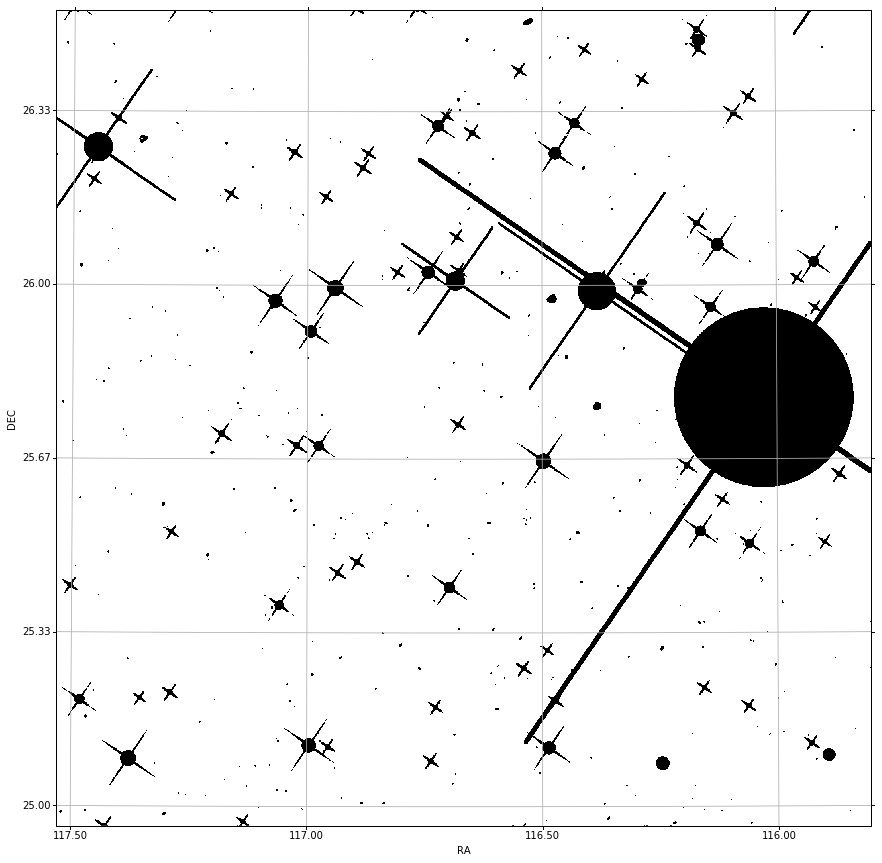

In [5]:
mask_bad = (data!=0) & (data!=(2**6))
print('fraction of masked arae:', np.sum(mask_bad)/len(mask_bad.flatten()))

plt.figure(figsize=(15, 15))
ax = plt.subplot(projection=wcs)
ax.imshow(mask_bad, origin='lower', cmap='Greys')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_autoscale_on(False)
# ax.scatter(116.667292, 25.745556, c='r', s=200, marker='*', transform=ax.get_transform('world'))
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
ax.grid()
plt.show()

fraction of masked arae: 0.0651426315308


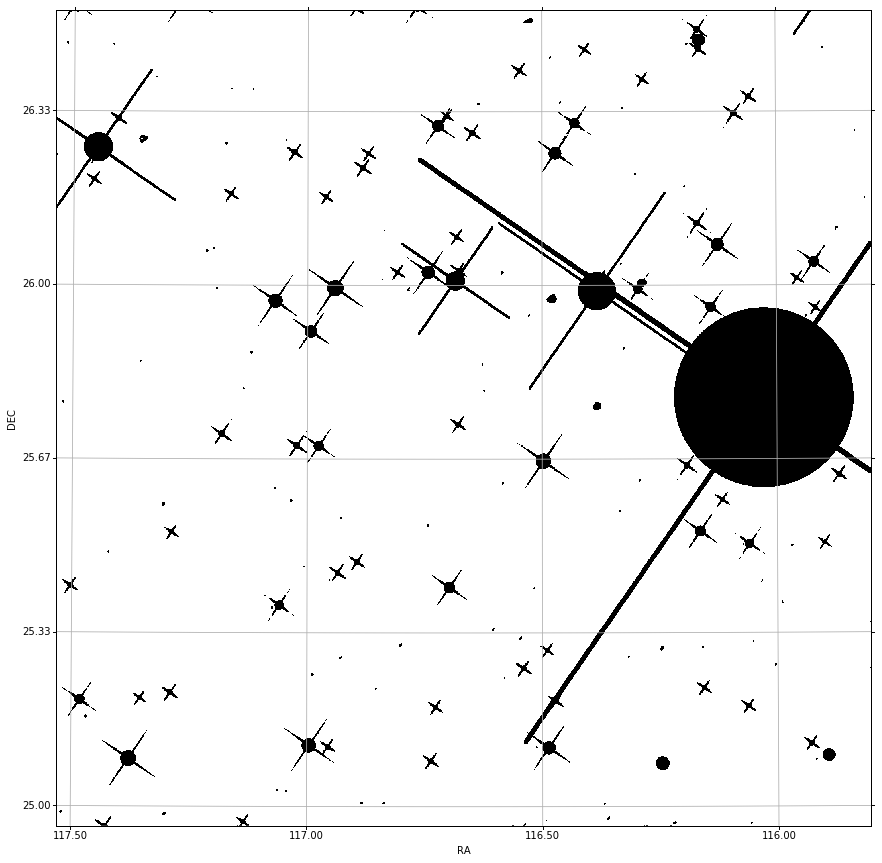

In [6]:
# No masking for galaxies
mask_bad = (data!=0) & (data!=(2**6)) & (data!=(2**9)) & (data!=(2**10))
print('fraction of masked arae:', np.sum(mask_bad)/len(mask_bad.flatten()))

plt.figure(figsize=(15, 15))
ax = plt.subplot(projection=wcs)
ax.imshow(mask_bad, origin='lower', cmap='Greys')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_autoscale_on(False)
# ax.scatter(116.667292, 25.745556, c='r', s=200, marker='*', transform=ax.get_transform('world'))
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
ax.grid()
plt.show()

In [6]:
# world = wcs.wcs_pix2world([[10, 10]], 1)

__Load WISE catalog values__

In [7]:
def solid_angle(ra1, dec1, ra2, dec2, return_steradian=True):
    '''
    Calculate the solid angle of a rectangle in the sky. The rectangle 
    is defined by its two corners (ra1, dec1) and (ra2, dec2), 
    where theta is the polar angle, in units of degrees. 

    Returns solid angle in steradian by default. 
    '''
    omega = np.abs(np.pi/180.*(ra2 - ra1)*(np.sin(dec2*np.pi/180) - np.sin(dec1*np.pi/180)))
    if return_steradian:
        return omega
    else:
        return omega*(180/np.pi)**2

# Create randoms that covers the image
ra_min, ra_max = np.min(coadd['ra_corners'][coadd_idx]), np.max(coadd['ra_corners'][coadd_idx])
dec_min, dec_max = np.min(coadd['dec_corners'][coadd_idx]), np.max(coadd['dec_corners'][coadd_idx])

density = 2000000
# brick area in 1/(sq deg)
brick_area = solid_angle(ra_min, dec_min, ra_max, dec_max, return_steradian=False)
nrand = int(round(brick_area * density))
print('nrand = ', nrand)

# Create random objects
u1,u2 = np.random.uniform(size=(2, nrand))
cmin = np.sin(dec_min*np.pi/180)
cmax = np.sin(dec_max*np.pi/180)
ra_rand = ra_min + u1*(ra_max-ra_min)
dec_rand = np.arcsin(cmin+u2*(cmax-cmin))*180./np.pi

nrand =  4926114


In [8]:
cat_flag, more_info = query_wise_catalog_mask.query_catalog_mask(ra_rand, dec_rand, 
                        diff_spikes=True, return_diagnostics=True, wise_cat_path='/global/homes/r/rongpu/mydesi/useful/w1_bright-13.3_trim_dr7_region_matched.fits')

-1.00 < W1mag < -0.50   0 WISE bright stars

-0.50 < W1mag < 0.00   0 WISE bright stars

0.00 < W1mag < 0.50   2 WISE bright stars
0 nearby objects
0 objects masked by circular mask
0 additionally objects masked by diffraction spikes mask
0 objects masked by the combined masks

0.50 < W1mag < 1.00   60 WISE bright stars
0 nearby objects
0 objects masked by circular mask
0 additionally objects masked by diffraction spikes mask
0 objects masked by the combined masks

1.00 < W1mag < 1.50   112 WISE bright stars
0 nearby objects
0 objects masked by circular mask
0 additionally objects masked by diffraction spikes mask
0 objects masked by the combined masks

1.50 < W1mag < 2.00   114 WISE bright stars
43330 nearby objects
21382 objects masked by circular mask
1382 additionally objects masked by diffraction spikes mask
22764 objects masked by the combined masks

2.00 < W1mag < 2.50   91 WISE bright stars
0 nearby objects
0 objects masked by circular mask
0 additionally objects masked by diff

In [9]:
np.sum(cat_flag)/len(cat_flag)

0.047649120584704295

__Compare the two masks__

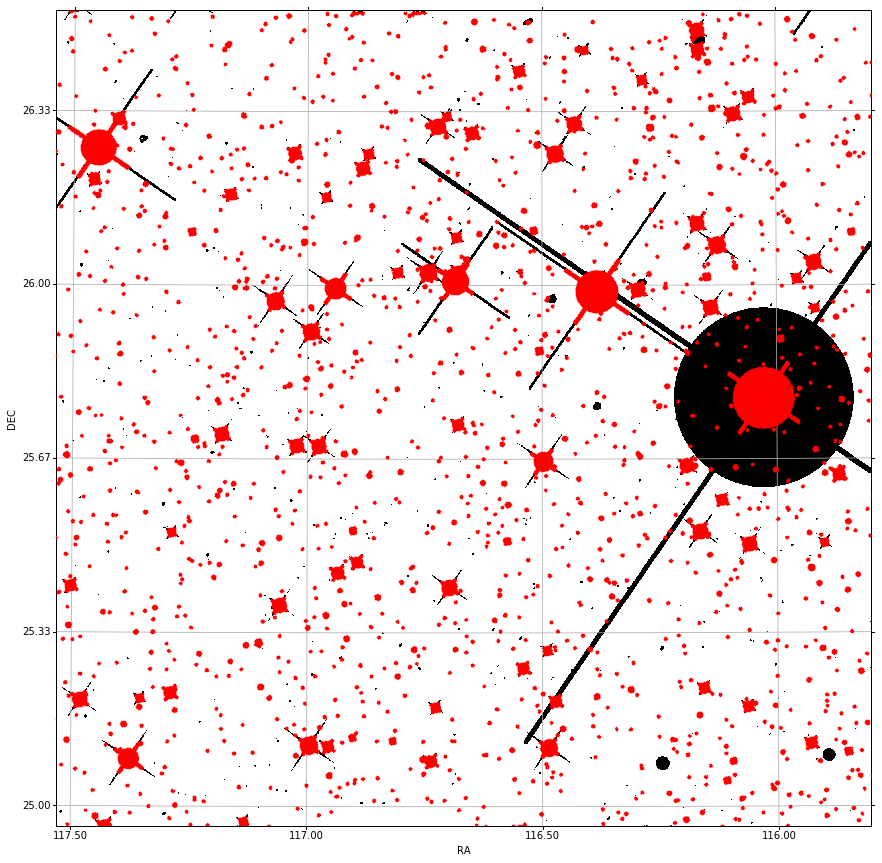

In [10]:
mask_bad = (data!=0) & (data!=(2**6))

plt.figure(figsize=(15, 15))
ax = plt.subplot(projection=wcs)
ax.imshow(mask_bad, origin='lower', cmap='Greys')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_autoscale_on(False)
ax.plot(ra_rand[cat_flag], dec_rand[cat_flag], 'r.', markersize=0.5, transform=ax.get_transform('world'))
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
ax.grid()
plt.show()

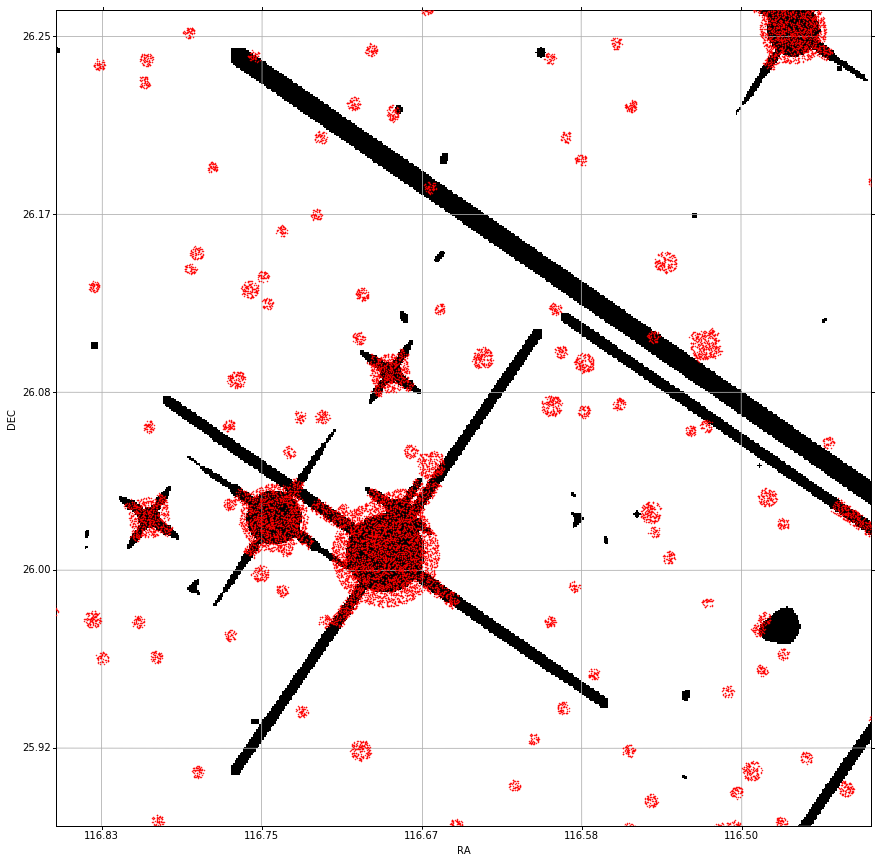

In [20]:
mask_bad = (data!=0) & (data!=(2**6))

plt.figure(figsize=(15, 15))
ax = plt.subplot(projection=wcs)
ax.imshow(mask_bad, origin='lower', cmap='Greys')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_autoscale_on(False)
ax.plot(ra_rand[cat_flag], dec_rand[cat_flag], 'r.', markersize=1., transform=ax.get_transform('world'))
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
ax.grid()
ax.axis([800, 1300, 1200, 1700])
plt.show()

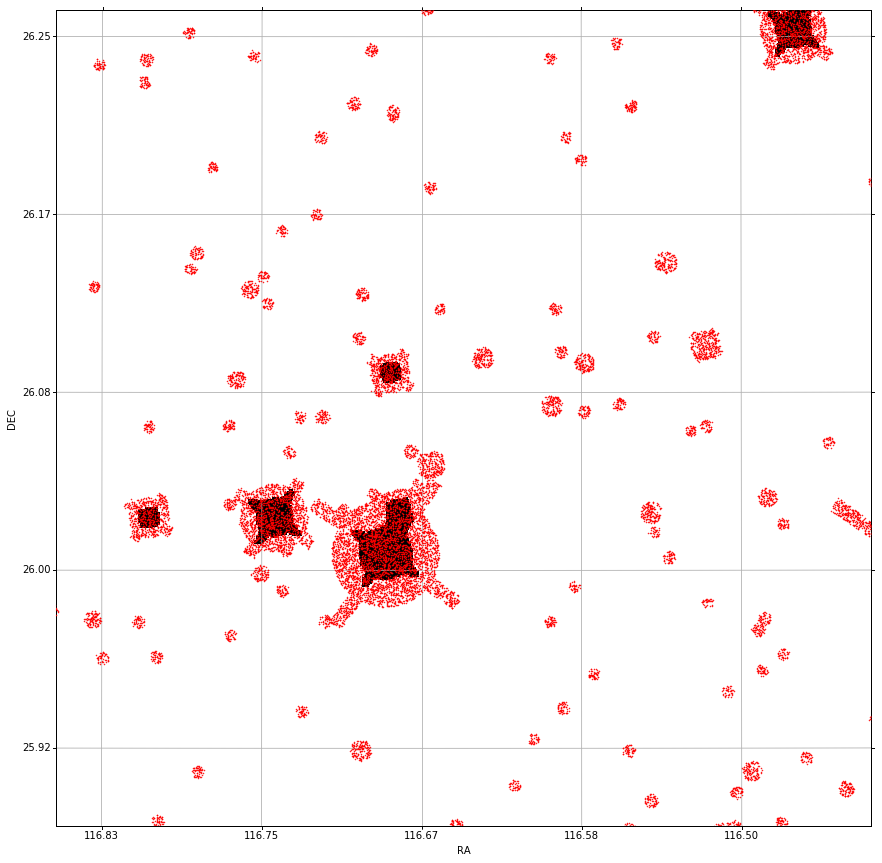

In [19]:
# Only the basic W1 mask
mask_bad = (data&(2**0)>0)| (data&(2**1)>0)

plt.figure(figsize=(15, 15))
ax = plt.subplot(projection=wcs)
ax.imshow(mask_bad, origin='lower', cmap='Greys')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_autoscale_on(False)
ax.plot(ra_rand[cat_flag], dec_rand[cat_flag], 'r.', markersize=1, transform=ax.get_transform('world'))
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
ax.grid()
ax.axis([800, 1300, 1200, 1700])
plt.show()

In [13]:
# Save the masked random points to disk
randoms = Table()
randoms['RA'] = ra_rand[cat_flag]
randoms['DEC'] = dec_rand[cat_flag]
randoms.write('/global/cscratch1/sd/rongpu/temp/unwise-1166p257-masked-radnsoms.fits')

---------
__Make plots each individual bitmask__

In [7]:
maskbit_names = ['W1 bright star, southward scan', 'W1 bright star, northward scan', 'W2 bright star, southward scan', 'W2 bright star, northward scan', 'W1 bright star saturation', 'W2 bright star saturation', 'center of pixel not primary', 'W1 bright star, centroid off edge', 'W2 bright star, centroid off edge', 'resolved galaxy', 'big object (LMC, SMC, M31)', 'W2 optical ghost, southward scan', 'W2 optical ghost, northward scan', 'W1 first latent, southward scan', 'W1 first latent, northward scan', 'W2 first latent, southward scan', 'W2 first latent, northward scan', 'W1 second latent, southward scan', 'W1 second latent, northward scan', 'W2 second latent, southward scan', 'W2 second latent, northward scan', 'may contain W1 bright star centroid', 'may contain W2 bright star centroid', 'AllWISE-like W1 circular halo', 'AllWISE-like W2 circular halo', 'W1 optical ghost, southward scan', 'W1 optical ghost, northward scan', 'PSF-based W1 diffraction spike', 'PSF-based W2 diffraction spike', 'geometric W1 diffraction spike', 'geometric W2 diffraction spike']

for index in range(len(maskbit_names)):
    mask_bad = (data&(2**index)>0)
    plt.figure(figsize=(15, 15))
    ax = plt.subplot(projection=wcs)
    ax.imshow(mask_bad, origin='lower', cmap='Greys')
    ax.set_xlabel('RA')
    ax.set_ylabel('DEC')
    ax.set_autoscale_on(False)
    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_major_formatter('d.dd')
    lat.set_major_formatter('d.dd')
    ax.grid()
    ax.set_title(maskbit_names[index])
    plt.savefig('/global/homes/r/rongpu/scratch/temp/unwise_bitmask/{}.png'.format(index))
    plt.close()

-----------
__Create randoms that overlap with the galaxy mask__

In [10]:
# Create randoms that covers the image
ra_min, ra_max = np.min(coadd['ra_corners'][coadd_idx]), np.max(coadd['ra_corners'][coadd_idx])
dec_min, dec_max = np.min(coadd['dec_corners'][coadd_idx]), np.max(coadd['dec_corners'][coadd_idx])

density = 100000
# brick area in 1/(sq deg)
brick_area = solid_angle(ra_min, dec_min, ra_max, dec_max, return_steradian=False)
nrand = int(round(brick_area * density))
print('nrand = ', nrand)

# Create random objects
u1,u2 = np.random.uniform(size=(2, nrand))
cmin = np.sin(dec_min*np.pi/180)
cmax = np.sin(dec_max*np.pi/180)
ra_rand = ra_min + u1*(ra_max-ra_min)
dec_rand = np.arcsin(cmin+u2*(cmax-cmin))*180./np.pi

################################################

world = np.column_stack([ra_rand, dec_rand])
pixcrd = wcs.wcs_world2pix(world, True)
mask = (pixcrd[:, 0]>0.5) & (pixcrd[:, 0]<2048.5)
mask &= (pixcrd[:, 1]>0.5) & (pixcrd[:, 1]<2048.5)
pixcrd = pixcrd[mask]
ra_rand = ra_rand[mask]
dec_rand = dec_rand[mask]

pixcrd_x, pixcrd_y = pixcrd.transpose()

# Convert the coordinates to integers with zero-based numbering of Python
pixcrd_x = np.round(pixcrd_x-1.).astype(int)
pixcrd_y = np.round(pixcrd_y-1.).astype(int)

mask_rand = data[pixcrd_y, pixcrd_x]&(2**9)>0

nrand =  246306


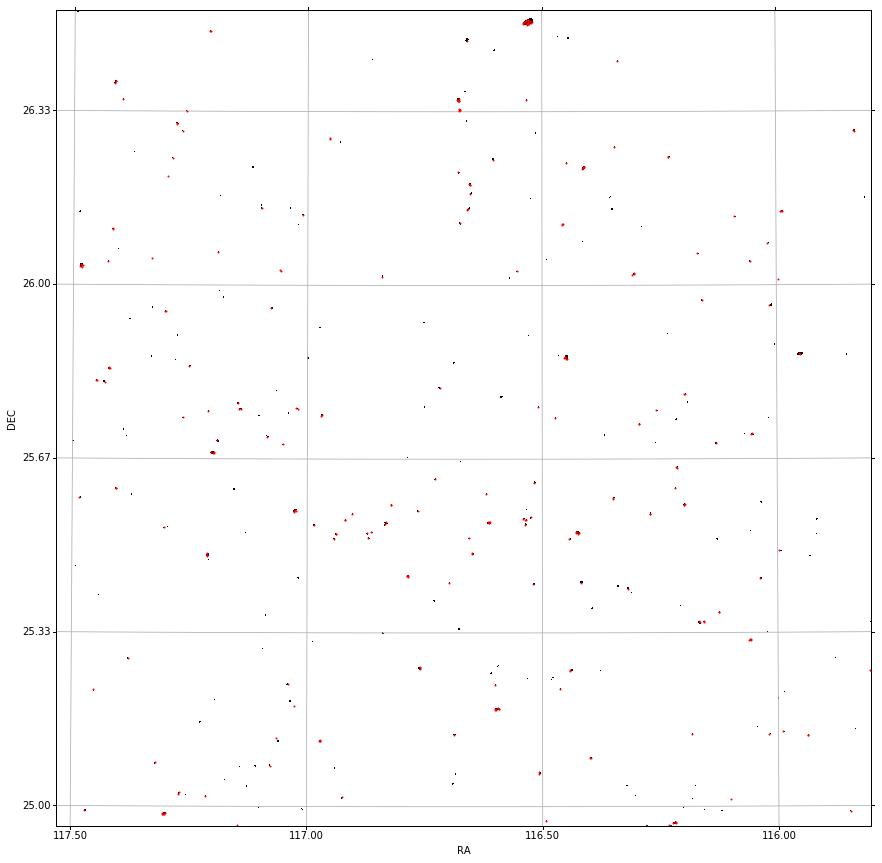

In [11]:
mask_bad = (data&(2**9)>0)

plt.figure(figsize=(15, 15))
ax = plt.subplot(projection=wcs)
ax.imshow(mask_bad, origin='lower', cmap='Greys')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_autoscale_on(False)
ax.plot(ra_rand[mask_rand], dec_rand[mask_rand], 'r.', markersize=2, transform=ax.get_transform('world'))
# ax.plot(pixcrd_x[mask_rand], pixcrd_y[mask_rand], 'r.', markersize=1)
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
ax.grid()
plt.show()

In [ ]:
# Save the masked random points to disk
randoms = Table()
randoms['RA'] = ra_rand[mask_rand]
randoms['DEC'] = dec_rand[mask_rand]
randoms.write('/global/cscratch1/sd/rongpu/temp/unwise-1166p257-masked-radnsoms-maskb9.fits')